In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load Data

In [3]:
scaler = StandardScaler()

In [4]:
X_train = scaler.fit_transform(np.loadtxt('X_train_feature1.csv', delimiter=','))

In [5]:
X_up_test = scaler.transform(np.loadtxt('X_up_test_feature1.csv', delimiter=','))
X_down_test = scaler.transform(np.loadtxt('X_down_test_feature1.csv', delimiter=','))
X_updown_test = scaler.transform(np.loadtxt('X_updown_test_feature1.csv', delimiter=','))
y_train = np.loadtxt('y_train_label1.csv', delimiter=',')
y_up_test = np.loadtxt('y_up_test_label1.csv', delimiter=',')
y_down_test = np.loadtxt('y_down_test_label1.csv', delimiter=',')
y_updown_test = np.loadtxt('y_updown_test_label1.csv', delimiter=',')

## Downsampling training

In [43]:
BUY = 0
HOLD = 1
SELL = 2

(array([ 1904.,     0.,     0.,     0.,     0., 48599.,     0.,     0.,
            0.,  1904.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

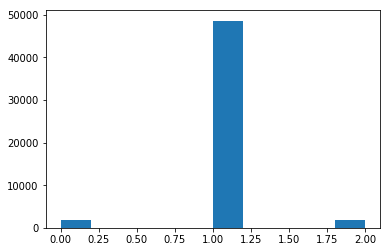

In [44]:
plt.hist(y_train)

num of buy = num of sell

In [45]:
len(np.where(y_train == BUY)[0]) - len(np.where(y_train == SELL)[0])

0

In [46]:
buysell_idx = np.append(np.where(y_train == BUY)[0], np.where(y_train == SELL)[0])

In [47]:
sample = len(np.where(y_train == BUY)[0])

In [48]:
sample_idx = np.where(y_train == HOLD)[0][np.random.permutation(sample)]

In [49]:
equal_idx = np.append(buysell_idx, sample_idx)

In [50]:
X_train = X_train[equal_idx]

In [51]:
y_train = y_train[equal_idx]

(array([1904.,    0.,    0.,    0.,    0., 1904.,    0.,    0.,    0.,
        1904.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

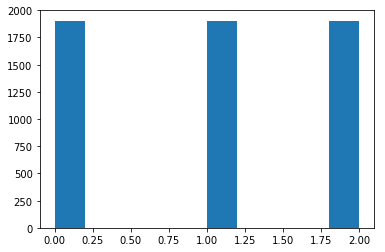

In [52]:
plt.hist(y_train)

# Machine Learning Models

In [29]:
from sklearn.metrics import classification_report

In [30]:
def sklearn_experiment(clf):
    %matplotlib inline
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    print('training')
    print(classification_report(y_train, y_pred_train, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual training')
    plt.hist(y_train)
    plt.figure(figsize=(7,4))
    plt.title('predicted training')
    plt.hist(y_pred_train)
    
    print('\n\n\ntesting on up data')
    y_pred_test = clf.predict(X_up_test)
    print(classification_report(y_up_test, y_pred_test, target_names=['buy', 'hold', 'sell']))
    plt.figure(figsize=(7,4))
    plt.title('actual test')
    plt.hist(y_up_test)
    plt.figure(figsize=(7,4))
    plt.title('predicted test')
    plt.hist(y_pred_test)

## Generalized Linear Models

In [64]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

training
              precision    recall  f1-score   support

         buy       0.35      0.37      0.36      1904
        hold       0.38      0.26      0.31      1904
        sell       0.35      0.43      0.38      1904

   micro avg       0.35      0.35      0.35      5712
   macro avg       0.36      0.35      0.35      5712
weighted avg       0.36      0.35      0.35      5712




testing on up data
              precision    recall  f1-score   support

         buy       0.00      0.00      0.00      1020
        hold       0.88      0.98      0.93     15577
        sell       0.00      0.00      0.00       962

   micro avg       0.87      0.87      0.87     17559
   macro avg       0.29      0.33      0.31     17559
weighted avg       0.78      0.87      0.82     17559



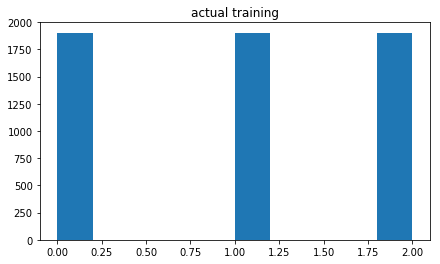

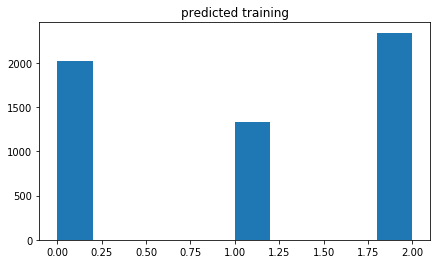

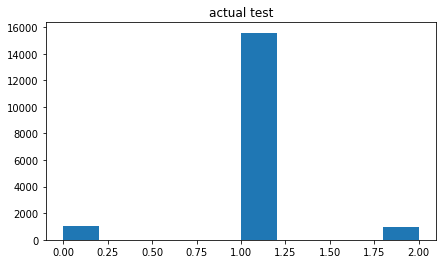

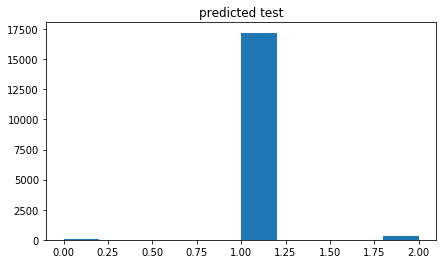

In [77]:
sklearn_experiment(LogisticRegression(solver='lbfgs', max_iter=200, multi_class='multinomial'))

training
              precision    recall  f1-score   support

         buy       0.32      0.20      0.25      1904
        hold       0.32      0.41      0.36      1904
        sell       0.36      0.39      0.37      1904

   micro avg       0.33      0.33      0.33      5712
   macro avg       0.33      0.33      0.33      5712
weighted avg       0.33      0.33      0.33      5712




testing on up data
              precision    recall  f1-score   support

         buy       0.00      0.00      0.00      1020
        hold       0.89      0.99      0.93     15577
        sell       0.00      0.00      0.00       962

   micro avg       0.87      0.87      0.87     17559
   macro avg       0.30      0.33      0.31     17559
weighted avg       0.79      0.87      0.83     17559



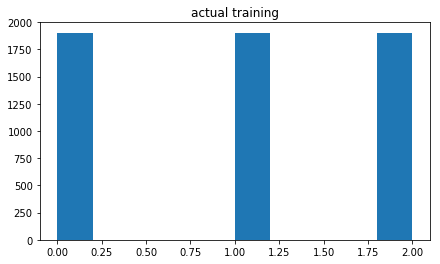

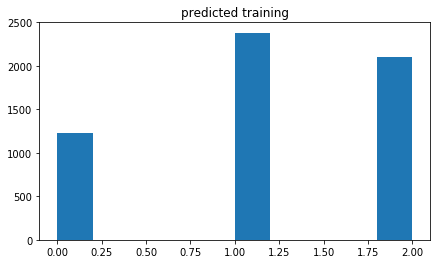

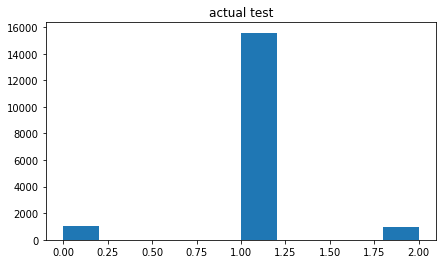

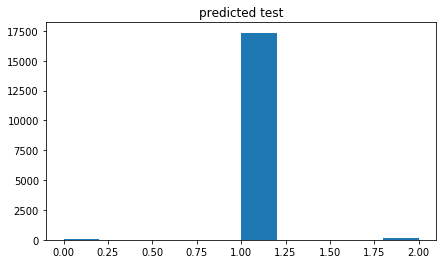

In [78]:
sklearn_experiment(SGDClassifier(max_iter=1000, tol=1e-3))

## Ensemble Models

In [90]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

training
              precision    recall  f1-score   support

         buy       1.00      1.00      1.00      1904
        hold       1.00      1.00      1.00      1904
        sell       1.00      1.00      1.00      1904

   micro avg       1.00      1.00      1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712




testing on up data
              precision    recall  f1-score   support

         buy       0.06      0.18      0.09      1020
        hold       0.89      0.62      0.73     15577
        sell       0.06      0.25      0.10       962

   micro avg       0.57      0.57      0.57     17559
   macro avg       0.34      0.35      0.31     17559
weighted avg       0.80      0.57      0.66     17559



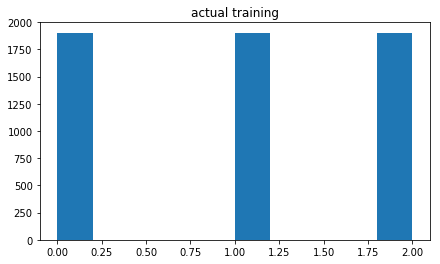

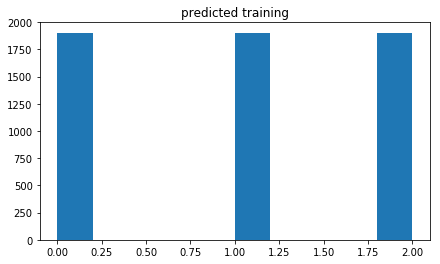

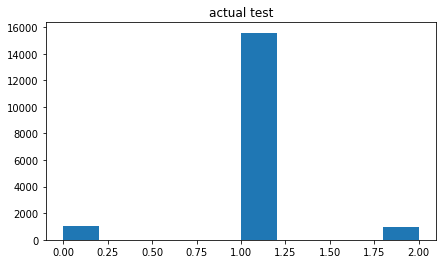

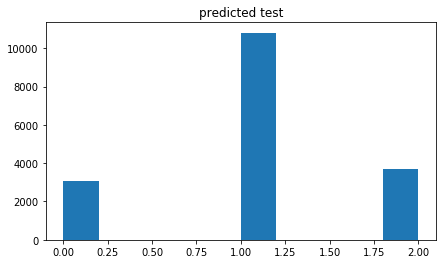

In [81]:
sklearn_experiment(RandomForestClassifier(n_estimators=200))

training
              precision    recall  f1-score   support

         buy       0.42      0.43      0.42      1904
        hold       0.59      0.55      0.57      1904
        sell       0.46      0.47      0.46      1904

   micro avg       0.48      0.48      0.48      5712
   macro avg       0.49      0.48      0.49      5712
weighted avg       0.49      0.48      0.49      5712




testing on up data
              precision    recall  f1-score   support

         buy       0.02      0.03      0.03      1020
        hold       0.92      0.27      0.41     15577
        sell       0.06      0.77      0.12       962

   micro avg       0.28      0.28      0.28     17559
   macro avg       0.34      0.36      0.19     17559
weighted avg       0.82      0.28      0.37     17559



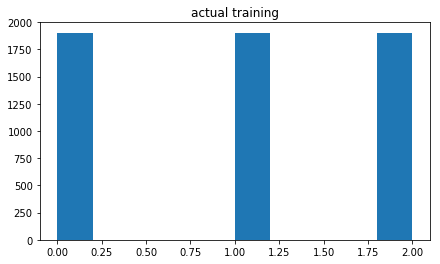

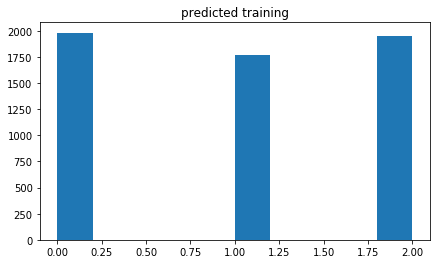

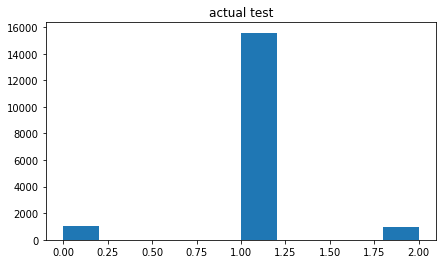

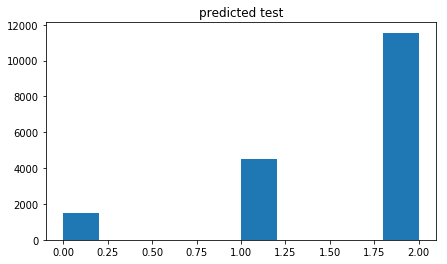

In [84]:
sklearn_experiment(AdaBoostClassifier(n_estimators=250))

training
              precision    recall  f1-score   support

         buy       0.55      0.59      0.57      1904
        hold       0.67      0.60      0.63      1904
        sell       0.58      0.59      0.58      1904

   micro avg       0.59      0.59      0.59      5712
   macro avg       0.60      0.59      0.60      5712
weighted avg       0.60      0.59      0.60      5712




testing on up data
              precision    recall  f1-score   support

         buy       0.02      0.03      0.03      1020
        hold       0.92      0.64      0.76     15577
        sell       0.10      0.52      0.17       962

   micro avg       0.60      0.60      0.60     17559
   macro avg       0.35      0.40      0.32     17559
weighted avg       0.82      0.60      0.68     17559



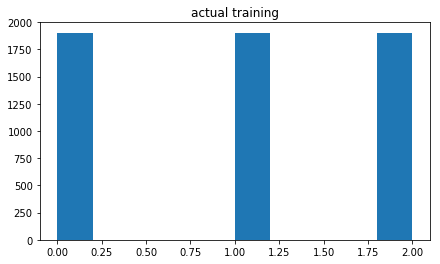

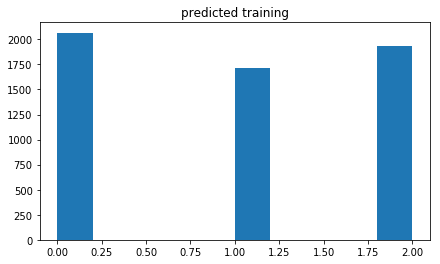

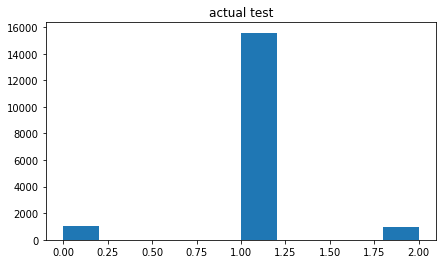

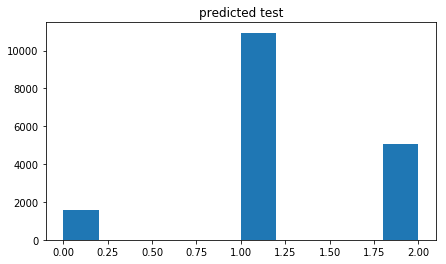

In [86]:
sklearn_experiment(GradientBoostingClassifier(n_estimators=150))

# Predict when to buy first.. 

In [76]:
X_train_buy_nobuy = X_train[np.where(y_train != 2)]
y_train_buy_nobuy = y_train[np.where(y_train != 2)]
X_up_test_buy_nobuy = X_up_test[np.where(y_up_test != 2)]
y_up_test_buy_nobuy = y_up_test[np.where(y_up_test != 2)]

In [135]:
clf = GradientBoostingClassifier(n_estimators=1000)

In [136]:
clf.fit(X_train_buy_nobuy, y_train_buy_nobuy)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [137]:
print(classification_report(
    y_train_buy_nobuy, clf.predict(X_train_buy_nobuy), target_names=['buy', 'don\'t']
))

              precision    recall  f1-score   support

         buy       0.90      0.96      0.93      1904
       don't       0.96      0.90      0.93      1904

   micro avg       0.93      0.93      0.93      3808
   macro avg       0.93      0.93      0.93      3808
weighted avg       0.93      0.93      0.93      3808



In [138]:
print(classification_report(
    y_up_test_buy_nobuy, clf.predict(X_up_test_buy_nobuy), target_names=['buy', 'don\'t']
))

              precision    recall  f1-score   support

         buy       0.08      0.54      0.14      1020
       don't       0.95      0.61      0.75     15577

   micro avg       0.61      0.61      0.61     16597
   macro avg       0.52      0.58      0.45     16597
weighted avg       0.90      0.61      0.71     16597

